In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import os
import torchvision
from torchvision import transforms as tvt
import torch
from torch import optim
from torch.nn import parallel
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pathlib
import random
import skimage
import cv2
from torchvision import ops
import time


In [2]:
#Implement projections and gating mechanisms in the Gated Recurrent Network:

class GruNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GruNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #weights to create the hidden gate, zt
        self.fc_hidden_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        #weights to create the reset gate
        self.fc_reset_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        #weights to create the candidate hidden state
        self.fc_hidden_state = nn.Linear(input_size + hidden_size, hidden_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        
        
    def forward(self, x, ht_minus1):
        #create zt, the hidden gate
        concat_xt_ht_minus1 = torch.cat((x, ht_minus1), dim = 0)
        pre_act_update_gate = self.fc_hidden_gate(concat_xt_ht_minus1)
        zt = sigmoid(pre_act_update_gate) #zt, update gate, created
        
        #create rt, the reset gate
        pre_act_reset_gate = self.fc_reset_gate(concat_xt_ht_minus1)
        rt = sigmoid(pre_act_reset_gate)
        #print(rt.shape)
        
        #create ht_tilde, the candidate hidden state
        pre_act_hidden_state = self.fc_hidden_state(concat_xt_ht_minus1)
        ht_candidate = self.tanh(pre_act_hidden_state)
        #print(ht_candidate.shape)
        
        #create new hidden state, which weights 1 - hidden gate element wise multiplied by prev hidden state 
        # added to hidden gate element wise multipled by the candidate hidden
        ht_new = (((1 - zt) * ht_minus1) + (zt * ht_candidate))

        return  ht_new
    
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.gru = GruNet(input_size, hidden_size) #instantiate GRU
        self.fc = nn.Linear(100, 2)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim = 0)
    
    def forward(self, x):
        for i, word_emb in enumerate(range(x.shape[0])): #this loop runs GRU for each embedding and hidden vector
            if i == 0: #no hidden state yet, init to 0:
                ht_new = torch.zeros(100)
                ht_new = self.gru(x[word_emb], ht_new)

            else:
                ht_new = self.gru(x[word_emb], ht_new)
        
        out = self.fc(self.relu(ht_new)) #take last hidden state vector to output size (2)
        out = self.logsoftmax(out) #apply logsoftmax activation (before computing NLL Loss outside of the class)
        
        return out
        

        
test = GruNet(300, 100)


In [4]:
#Implement logic to get the Word2Vec embeddings:
# Use DL studio to get sentiment data we want to train:
import gzip
import os, sys
import pickle
print(os.getcwd())
dataset_archive_train = "data/sentiment_dataset_train_400.tar.gz"
dataset_archive_test =  "data/sentiment_dataset_test_400.tar.gz"
path_to_saved_embeddings = "word2vec_saved_embeddings/"
dataroot = "/Users/alim/Documents/ECE60146/hw8/"




class MiniDLStudio():
    def __init__(self,dataroot, path_saved_model, momentum, learning_rate,
                  epochs, batch_size, classes, use_gpu):
        self.dataroot = dataroot
        self.path_saved_model = path_saved_model
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes = classes
        self.use_gpu = use_gpu

dls = MiniDLStudio(
                  dataroot = dataroot,
                  path_saved_model = "./saved_model",
                  momentum = 0.9,
                  learning_rate =  1e-5,
                  epochs = 1,
                  batch_size = 1,
                  classes = ('negative','positive'),
                  use_gpu = False
              )





/Users/alim/Documents/ECE60146/hw8


In [8]:
class TextClassificationWithEmbeddings(nn.Module):             
        """
        The text processing class described previously, TextClassification, was based on
        using one-hot vectors for representing the words.  The main challenge we faced
        with one-hot vectors was that the larger the size of the training dataset, the
        larger the size of the vocabulary, and, therefore, the larger the size of the
        one-hot vectors.  The increase in the size of the one-hot vectors led to a
        model with a significantly larger number of learnable parameters --- and, that,
        in turn, created a need for a still larger training dataset.  Sounds like a classic
        example of a vicious circle.  In this section, I use the idea of word embeddings
        to break out of this vicious circle.

        Word embeddings are fixed-sized numerical representations for words that are
        learned on the basis of the similarity of word contexts.  The original and still
        the most famous of these representations are known as the word2vec
        embeddings. The embeddings that I use in this section consist of pre-trained
        300-element word vectors for 3 million words and phrases as learned from Google
        News reports.  I access these embeddings through the popular Gensim library.
 
        Class Path:  DLStudio -> TextClassificationWithEmbeddings
        """
        def __init__(self, dl_studio, dataserver_train=None,dataserver_test=None,dataset_file_train=None,dataset_file_test=None):
            super(TextClassificationWithEmbeddings, self).__init__()
            self.dl_studio = dl_studio
            self.dataserver_train = dataserver_train
            self.dataserver_test = dataserver_test

        class SentimentAnalysisDataset(torch.utils.data.Dataset):
            """
            In relation to the SentimentAnalysisDataset defined for the TextClassification section of 
            DLStudio, the __getitem__() method of the dataloader must now fetch the embeddings from
            the word2vec word vectors.

            Class Path:  DLStudio -> TextClassificationWithEmbeddings -> SentimentAnalysisDataset
            """
            def __init__(self, dl_studio, train_or_test, dataset_file, path_to_saved_embeddings=None):
                super(TextClassificationWithEmbeddings.SentimentAnalysisDataset, self).__init__()
                import gensim.downloader as gen_api
#                self.word_vectors = gen_api.load("word2vec-google-news-300")
                self.path_to_saved_embeddings = path_to_saved_embeddings
                self.train_or_test = train_or_test
                root_dir = dl_studio.dataroot
                f = gzip.open(root_dir + dataset_file, 'rb')
                dataset = f.read()
                if path_to_saved_embeddings is not None:
                    import gensim.downloader as genapi
                    from gensim.models import KeyedVectors 
                    if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                        self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
                    else:
                        print("""\n\nSince this is your first time to install the word2vec embeddings, it may take"""
                              """\na couple of minutes. The embeddings occupy around 3.6GB of your disk space.\n\n""")
                        self.word_vectors = genapi.load("word2vec-google-news-300")               
                        ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it 
                        ##  has a smaller footprint than dict
                        self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')    
                if train_or_test == 'train':
                    if sys.version_info[0] == 3:
                        self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
                    self.categories = sorted(list(self.positive_reviews_train.keys()))
                    self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
                    self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
                    self.indexed_dataset_train = []
                    for category in self.positive_reviews_train:
                        for review in self.positive_reviews_train[category]:
                            self.indexed_dataset_train.append([review, category, 1])
                    for category in self.negative_reviews_train:
                        for review in self.negative_reviews_train[category]:
                            self.indexed_dataset_train.append([review, category, 0])
                    random.shuffle(self.indexed_dataset_train)
                elif train_or_test == 'test':
                    if sys.version_info[0] == 3:
                        self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
                    else:
                        self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
                    self.vocab = sorted(self.vocab)
                    self.categories = sorted(list(self.positive_reviews_test.keys()))
                    self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
                    self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
                    self.indexed_dataset_test = []
                    for category in self.positive_reviews_test:
                        for review in self.positive_reviews_test[category]:
                            self.indexed_dataset_test.append([review, category, 1])
                    for category in self.negative_reviews_test:
                        for review in self.negative_reviews_test[category]:
                            self.indexed_dataset_test.append([review, category, 0])
                    random.shuffle(self.indexed_dataset_test)

            def review_to_tensor(self, review):
                list_of_embeddings = []
                for i,word in enumerate(review):
                    if word in self.word_vectors.key_to_index:
                        embedding = self.word_vectors[word]
                        list_of_embeddings.append(np.array(embedding))
                    else:
                        next
                review_tensor = torch.FloatTensor( list_of_embeddings )
                return review_tensor

            def sentiment_to_tensor(self, sentiment):
                """
                Sentiment is ordinarily just a binary valued thing.  It is 0 for negative
                sentiment and 1 for positive sentiment.  We need to pack this value in a
                two-element tensor.
                """        
                sentiment_tensor = torch.zeros(2)
                if sentiment == 1:
                    sentiment_tensor[1] = 1
                elif sentiment == 0: 
                    sentiment_tensor[0] = 1
                sentiment_tensor = sentiment_tensor.type(torch.long)
                return sentiment_tensor

            def __len__(self):
                if self.train_or_test == 'train':
                    return len(self.indexed_dataset_train)
                elif self.train_or_test == 'test':
                    return len(self.indexed_dataset_test)

            def __getitem__(self, idx):
                sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
                review = sample[0]
                review_category = sample[1]
                review_sentiment = sample[2]
                review_sentiment = self.sentiment_to_tensor(review_sentiment)
                review_tensor = self.review_to_tensor(review)
                category_index = self.categories.index(review_category)
                sample = {'review'       : review_tensor, 
                          'category'     : category_index, # should be converted to tensor, but not yet used
                          'sentiment'    : review_sentiment }
                return sample

        def load_SentimentAnalysisDataset(self, dataserver_train, dataserver_test ):   
            self.train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                        batch_size=self.dl_studio.batch_size,shuffle=True, num_workers=2) #wraps the dataset in the dataloader!!!! Cool :) 
            self.test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                               batch_size=self.dl_studio.batch_size,shuffle=False, num_workers=2)
            
            
text_cl = TextClassificationWithEmbeddings(dl_studio = dls)
dataserver_train = text_cl.SentimentAnalysisDataset(dl_studio = dls, train_or_test = 'train', 
                                                       dataset_file = dataset_archive_train, 
                                                        path_to_saved_embeddings = path_to_saved_embeddings)

dataserver_test = TextClassificationWithEmbeddings.SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dl_studio = dls,
                                 dataset_file = dataset_archive_test,
                                 path_to_saved_embeddings = path_to_saved_embeddings
                  )
text_cl.dataserver_train = dataserver_train #assigns the dataserver_train to self.dataserver_train
text_cl.dataserver_test = dataserver_test #assigns the dataserver_test to self.dataserver_test

text_cl.load_SentimentAnalysisDataset(dataserver_train, dataserver_test) 



In [9]:
# print(text_cl.dataserver_train[1])
# print(text_cl.dataserver_train[23]['sentiment'].shape)
# print(text_cl.dataserver_test[4]['category'])
## DATALOADERS:
count = 0
for n, i in enumerate(text_cl.dataserver_test): ## text_cl.dataserver_train is the dataloader for the training data
#     if n < 1:
#         print(i['review'].shape) #will return the sequence of words in shape (num words in review, embedding_size)
#         # each word is represented as the word2vec embedding
#         print(i['category']) 
#         print(i['sentiment']) 
    count += 1
print(count)
        




/var/folders/48/fhkqgp2n7_q3vztw41t7y1wr0000gp/T/ipykernel_2912/3960304369.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  review_tensor = torch.FloatTensor( list_of_embeddings )


3563


In [434]:
#Training Loop for handcrafted GRU:
#GRUNet = GruNet(input_size = 300, hidden_size = 100)
rnn = RNN(input_size =300, hidden_size =100)
epochs = 4
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(),  lr=dls.learning_rate)
running_loss = 0.0
training_loss_tally_ownGRU = []
start_time = time.perf_counter()
for epoch in range(epochs):
    for n, data in enumerate(text_cl.dataserver_train):
        review = data['review'] #review is a tensor of embeddings
        sentiment = data['sentiment'] #sentiment is a tensor of GT sentiment: 
        out = rnn(review)
        target = torch.argmax(sentiment)
        loss = criterion(out, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if n % 200 == 199:    
            avg_loss = running_loss / float(200)
            training_loss_tally_ownGRU.append(avg_loss)
            current_time = time.perf_counter()
            time_elapsed = current_time-start_time
            print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,n+1, time_elapsed,avg_loss))
            running_loss = 0.0
                
                


            
        
    

[epoch:1  iter: 200  elapsed_time:   7 secs]     loss: 0.69056
[epoch:1  iter: 400  elapsed_time:  16 secs]     loss: 0.68833
[epoch:1  iter: 600  elapsed_time:  24 secs]     loss: 0.69402
[epoch:1  iter: 800  elapsed_time:  31 secs]     loss: 0.67881
[epoch:1  iter:1000  elapsed_time:  39 secs]     loss: 0.65036
[epoch:1  iter:1200  elapsed_time:  47 secs]     loss: 0.64817
[epoch:1  iter:1400  elapsed_time:  54 secs]     loss: 0.64300
[epoch:1  iter:1600  elapsed_time:  61 secs]     loss: 0.58882
[epoch:1  iter:1800  elapsed_time:  68 secs]     loss: 0.61138
[epoch:1  iter:2000  elapsed_time:  76 secs]     loss: 0.60809
[epoch:1  iter:2200  elapsed_time:  84 secs]     loss: 0.58689
[epoch:1  iter:2400  elapsed_time:  91 secs]     loss: 0.49089
[epoch:1  iter:2600  elapsed_time:  98 secs]     loss: 0.50758
[epoch:1  iter:2800  elapsed_time: 104 secs]     loss: 0.48014
[epoch:1  iter:3000  elapsed_time: 112 secs]     loss: 0.57434
[epoch:1  iter:3200  elapsed_time: 119 secs]     loss: 

[epoch:2  iter:12000  elapsed_time:1004 secs]     loss: 0.34761
[epoch:2  iter:12200  elapsed_time:1011 secs]     loss: 0.39579
[epoch:2  iter:12400  elapsed_time:1019 secs]     loss: 0.32443
[epoch:2  iter:12600  elapsed_time:1026 secs]     loss: 0.30516
[epoch:2  iter:12800  elapsed_time:1034 secs]     loss: 0.37326
[epoch:2  iter:13000  elapsed_time:1041 secs]     loss: 0.32187
[epoch:2  iter:13200  elapsed_time:1049 secs]     loss: 0.38222
[epoch:2  iter:13400  elapsed_time:1057 secs]     loss: 0.28824
[epoch:2  iter:13600  elapsed_time:1066 secs]     loss: 0.31632
[epoch:2  iter:13800  elapsed_time:1074 secs]     loss: 0.33295
[epoch:2  iter:14000  elapsed_time:1081 secs]     loss: 0.34294
[epoch:2  iter:14200  elapsed_time:1088 secs]     loss: 0.30870
[epoch:3  iter: 200  elapsed_time:1097 secs]     loss: 0.36094
[epoch:3  iter: 400  elapsed_time:1105 secs]     loss: 0.30304
[epoch:3  iter: 600  elapsed_time:1113 secs]     loss: 0.32294
[epoch:3  iter: 800  elapsed_time:1121 secs

[epoch:4  iter:9600  elapsed_time:2003 secs]     loss: 0.24957
[epoch:4  iter:9800  elapsed_time:2011 secs]     loss: 0.17629
[epoch:4  iter:10000  elapsed_time:2018 secs]     loss: 0.22177
[epoch:4  iter:10200  elapsed_time:2025 secs]     loss: 0.13509
[epoch:4  iter:10400  elapsed_time:2033 secs]     loss: 0.17365
[epoch:4  iter:10600  elapsed_time:2040 secs]     loss: 0.21828
[epoch:4  iter:10800  elapsed_time:2048 secs]     loss: 0.29209
[epoch:4  iter:11000  elapsed_time:2056 secs]     loss: 0.15493
[epoch:4  iter:11200  elapsed_time:2063 secs]     loss: 0.21403
[epoch:4  iter:11400  elapsed_time:2070 secs]     loss: 0.21232
[epoch:4  iter:11600  elapsed_time:2078 secs]     loss: 0.19837
[epoch:4  iter:11800  elapsed_time:2085 secs]     loss: 0.15468
[epoch:4  iter:12000  elapsed_time:2094 secs]     loss: 0.23152
[epoch:4  iter:12200  elapsed_time:2101 secs]     loss: 0.25876
[epoch:4  iter:12400  elapsed_time:2108 secs]     loss: 0.21568
[epoch:4  iter:12600  elapsed_time:2115 se

Text(0.5, 1.0, 'Loss over Training for own GRU')

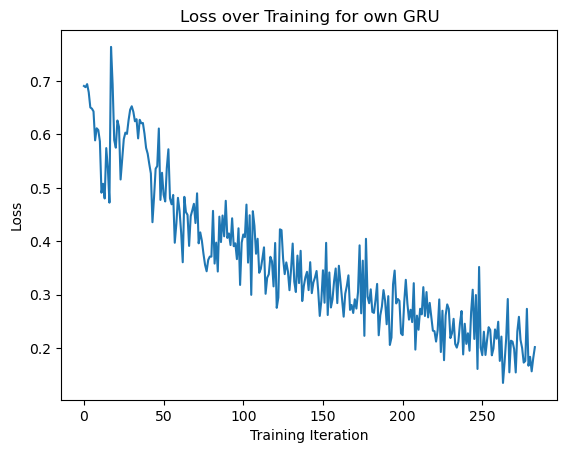

In [435]:
plt.plot(training_loss_tally_ownGRU)
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss over Training for own GRU")

In [22]:
### Prediction / Eval Code for my own GRU:
correct_pos_sentiment = 0.0
total_pos_sentiment = 0.0
correct_neg_sentiment = 0.0
total_neg_sentiment = 0.0
sentiment_pred = []
sentiment_label = []
mapping = { 0 : 'negative', 1: 'positive'}
with torch.no_grad():
    for n, data in enumerate(text_cl.dataserver_test):

            #print('n is', n)
            sentiment = data['sentiment']
            review = data['review']
            out = rnn(review) #goes through one sequence of embeddings (i.e one review)

            GT = torch.argmax(sentiment).item()
            sentiment_label.append(mapping[GT])
            pred = torch.argmax(out).item()
            sentiment_pred.append(mapping[pred])
            if (GT == 1): #compute positive sentiment accuracy
                total_pos_sentiment += 1
                if pred == GT:
                    #print('accurate pos sentiment pred')
                    correct_pos_sentiment += 1

            if (GT == 0): #compute negative sentiment accuracy
                total_neg_sentiment += 1
                if pred == GT:
                    #print('accurate neg sentiment pred')
                    correct_neg_sentiment += 1


    print("total acc for pos:        total acc for neg:")       
    print(correct_pos_sentiment / total_pos_sentiment, '         ', correct_neg_sentiment / total_neg_sentiment)
    print('total accuracy:', (correct_pos_sentiment + correct_neg_sentiment) / len(sentiment_label))        
        
from sklearn.metrics import confusion_matrix
y_true = sentiment_label
y_pred = sentiment_pred
print(len(y_true), len(y_pred))
confusion_matrix=confusion_matrix(y_true, y_pred, labels = [ "positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels = [ "positive", "negative"])
disp.plot()
disp.ax_.set_title("Confusion Matrix for Sentiment Predictor using own GRU")
plt.show()


NameError: name 'rnn' is not defined

In [361]:
#test logsoftmax. Equation is log [(exp(xi)) / sum of all the exp(xj) ] 
m = nn.LogSoftmax(dim=0)
input = torch.randn(2, 3)
output = m(input)
print(output)

#intuition for NLLLoss. I think it is basically -wn * xn, where xn is the input with a logsoftmax applied. 
nll = nn.NLLLoss()
input_ = torch.tensor([0.2, 0.8])
#input_ = input_.type(torch.LongTensor)

target = torch.tensor(0, dtype=torch.long)
#target = target.type(torch.LongTensor) 
loss = nll(m(input_), target)
print(loss)

print(m(input_))
d = np.exp(0) + np.exp(1)
n = np.exp(1)
print(d)
print(n)

print(np.log(n / d))

tensor([[-1.3331, -0.2350, -0.7795],
        [-0.3061, -1.5633, -0.6137]])
tensor(1.0375)
tensor([-1.0375, -0.4375])
3.718281828459045
2.718281828459045
-0.3132616875182228


In [437]:
class GRUNetPyTorch(nn.Module):
    """
    For this embeddings adapted version of the GRUnet shown earlier, we can assume that
    the 'input_size' for a tensor representing a word is always 300.
    Source: https://blog.floydhub.com/gru-with-pytorch/
    with the only modification that the final output of forward() is now
    routed through LogSoftmax activation. 

    Class Path:  DLStudio -> TextClassificationWithEmbeddings -> GRUnetWithEmbeddings 
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1): 
        """
        -- input_size is the size of the tensor for each word in a sequence of words.  If you word2vec
               embedding, the value of this variable will always be equal to 300.
        -- hidden_size is the size of the hidden state in the RNN
        -- output_size is the size of output of the RNN.  For binary classification of 
               input text, output_size is 2.
        -- num_layers creates a stack of GRUs
        """
        super(GRUNetPyTorch, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        #print("in input: x shp and then h shape:", x.shape, h.shape)
        out, h = self.gru(x, h)
        #print("after running through self.gru:", out.shape, h.shape)
        #print("out[:,-1].shape", out[:,-1].shape)
        out = self.fc(self.relu(out[:,-1]))
        
        #print("after relu applied to out [:,-1] and a fc(hidden size --> output size):", out.shape)
        out = self.logsoftmax(out)
        #print("output after logsoftmax:", out.shape)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        #                  num_layers  batch_size    hidden_size
        hidden = weight.new(  2,          1,         self.hidden_size    ).zero_()
        return hidden
    
"""
Output from Prof Kak's Implementation:
in input: x shp and then h shape: torch.Size([1, 1, 300]) torch.Size([2, 1, 100])
after running through self.gru: torch.Size([1, 1, 100]) torch.Size([2, 1, 100])
after relu applied to out [:,-1] and a fc(hidden size --> output size): torch.Size([1, 2])
output after logsoftmax: torch.Size([1, 2])
"""

"\nOutput from Prof Kak's Implementation:\nin input: x shp and then h shape: torch.Size([1, 1, 300]) torch.Size([2, 1, 100])\nafter running through self.gru: torch.Size([1, 1, 100]) torch.Size([2, 1, 100])\nafter relu applied to out [:,-1] and a fc(hidden size --> output size): torch.Size([1, 2])\noutput after logsoftmax: torch.Size([1, 2])\n"

In [438]:
model = GRUNetPyTorch(input_size = 300, hidden_size = 100, output_size = 2, num_layers=2)
epochs = 4
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),  lr=dls.learning_rate)
running_loss = 0.0
training_loss_tally_nnGRU = []
start_time = time.perf_counter()

for epoch in range(epochs):
    for n, data in enumerate(text_cl.dataserver_train):
        review = data['review']
        sentiment = data['sentiment']
        h = model.init_hidden()
        #print('h.shape:',h.shape)
        #input to an instance of torch.nn.GRU = tensor with shape seq len, batchsize, input_size

        review = torch.unsqueeze(review, 1) #reshape review, which originally is in seq len, input size shape
        #to have a first axis with size 1. 

        out, h = model(review, h)
        target = torch.argmax(sentiment)
        #print(out.shape, h.shape)
        #compute loss on output from GRU
        loss = criterion(out[-1,:], target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if n % 200 == 199:
            avg_loss = running_loss / float(200)
            training_loss_tally_nnGRU.append(avg_loss)
            current_time = time.perf_counter()
            time_elapsed = current_time-start_time
            print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,n+1, time_elapsed,avg_loss))
            running_loss = 0.0


            

[epoch:1  iter: 200  elapsed_time:   7 secs]     loss: 0.69291
[epoch:1  iter: 400  elapsed_time:  16 secs]     loss: 0.68735
[epoch:1  iter: 600  elapsed_time:  24 secs]     loss: 0.70055
[epoch:1  iter: 800  elapsed_time:  32 secs]     loss: 0.68407
[epoch:1  iter:1000  elapsed_time:  40 secs]     loss: 0.67397
[epoch:1  iter:1200  elapsed_time:  48 secs]     loss: 0.66132
[epoch:1  iter:1400  elapsed_time:  57 secs]     loss: 0.67084
[epoch:1  iter:1600  elapsed_time:  67 secs]     loss: 0.63884
[epoch:1  iter:1800  elapsed_time:  74 secs]     loss: 0.62712
[epoch:1  iter:2000  elapsed_time:  82 secs]     loss: 0.61636
[epoch:1  iter:2200  elapsed_time:  90 secs]     loss: 0.63050
[epoch:1  iter:2400  elapsed_time:  97 secs]     loss: 0.53462
[epoch:1  iter:2600  elapsed_time: 104 secs]     loss: 0.63246
[epoch:1  iter:2800  elapsed_time: 111 secs]     loss: 0.62303
[epoch:1  iter:3000  elapsed_time: 119 secs]     loss: 0.63409
[epoch:1  iter:3200  elapsed_time: 127 secs]     loss: 

[epoch:2  iter:12000  elapsed_time:1014 secs]     loss: 0.36866
[epoch:2  iter:12200  elapsed_time:1021 secs]     loss: 0.36028
[epoch:2  iter:12400  elapsed_time:1029 secs]     loss: 0.35827
[epoch:2  iter:12600  elapsed_time:1036 secs]     loss: 0.33087
[epoch:2  iter:12800  elapsed_time:1044 secs]     loss: 0.42757
[epoch:2  iter:13000  elapsed_time:1051 secs]     loss: 0.35459
[epoch:2  iter:13200  elapsed_time:1059 secs]     loss: 0.38286
[epoch:2  iter:13400  elapsed_time:1066 secs]     loss: 0.28373
[epoch:2  iter:13600  elapsed_time:1075 secs]     loss: 0.31272
[epoch:2  iter:13800  elapsed_time:1083 secs]     loss: 0.35104
[epoch:2  iter:14000  elapsed_time:1090 secs]     loss: 0.36839
[epoch:2  iter:14200  elapsed_time:1097 secs]     loss: 0.31984
[epoch:3  iter: 200  elapsed_time:1106 secs]     loss: 0.37317
[epoch:3  iter: 400  elapsed_time:1114 secs]     loss: 0.32014
[epoch:3  iter: 600  elapsed_time:1122 secs]     loss: 0.31993
[epoch:3  iter: 800  elapsed_time:1129 secs

[epoch:4  iter:9600  elapsed_time:2014 secs]     loss: 0.21442
[epoch:4  iter:9800  elapsed_time:2022 secs]     loss: 0.22526
[epoch:4  iter:10000  elapsed_time:2029 secs]     loss: 0.24349
[epoch:4  iter:10200  elapsed_time:2037 secs]     loss: 0.12692
[epoch:4  iter:10400  elapsed_time:2044 secs]     loss: 0.19332
[epoch:4  iter:10600  elapsed_time:2052 secs]     loss: 0.23919
[epoch:4  iter:10800  elapsed_time:2060 secs]     loss: 0.24421
[epoch:4  iter:11000  elapsed_time:2068 secs]     loss: 0.21998
[epoch:4  iter:11200  elapsed_time:2075 secs]     loss: 0.21980
[epoch:4  iter:11400  elapsed_time:2083 secs]     loss: 0.23057
[epoch:4  iter:11600  elapsed_time:2091 secs]     loss: 0.19214
[epoch:4  iter:11800  elapsed_time:2099 secs]     loss: 0.16020
[epoch:4  iter:12000  elapsed_time:2107 secs]     loss: 0.27064
[epoch:4  iter:12200  elapsed_time:2115 secs]     loss: 0.27555
[epoch:4  iter:12400  elapsed_time:2124 secs]     loss: 0.19099
[epoch:4  iter:12600  elapsed_time:2131 se

Text(0.5, 1.0, 'Loss over Training using nn.GRU')

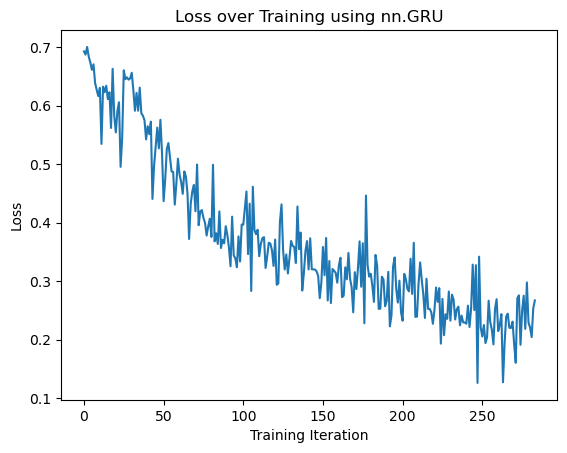

In [442]:
#Plot of loss over training for nn.GRU:
plt.plot(training_loss_tally_nnGRU)
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss over Training using nn.GRU")

total acc for pos:        total acc for neg:
0.8639455782312925           0.862590799031477
total accuracy: 0.8633174291327533
3563 3563


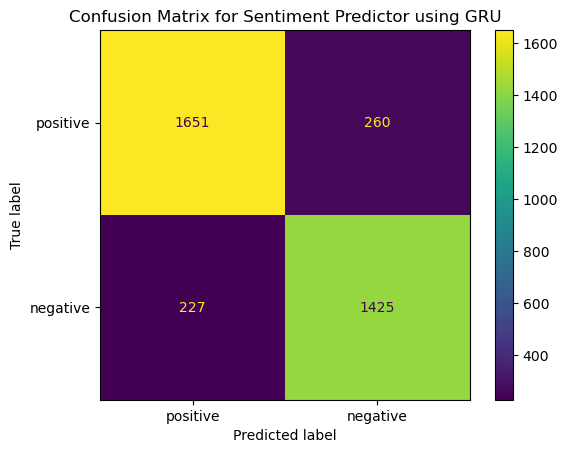

In [440]:
### Prediction / Eval Code for nn.GRU model
correct_pos_sentiment = 0.0
total_pos_sentiment = 0.0
correct_neg_sentiment = 0.0
total_neg_sentiment = 0.0
sentiment_pred = []
sentiment_label = []
mapping = { 0 : 'negative', 1: 'positive'}
with torch.no_grad():
    for n, data in enumerate(text_cl.dataserver_test):

            #print('n is', n)
            sentiment = data['sentiment']
            review = data['review']
            h = model.init_hidden()
            review = torch.unsqueeze(review, 1)
            out, h = model(review, h) #goes through one sequence of embeddings (i.e one review)

            GT = torch.argmax(sentiment).item()
            sentiment_label.append(mapping[GT])
            pred = torch.argmax(out[-1, :]).item()
            sentiment_pred.append(mapping[pred])
            if (GT == 1): #compute positive sentiment accuracy
                total_pos_sentiment += 1
                if pred == GT:
                    #print('accurate pos sentiment pred')
                    correct_pos_sentiment += 1

            if (GT == 0): #compute negative sentiment accuracy
                total_neg_sentiment += 1
                if pred == GT:
                    #print('accurate neg sentiment pred')
                    correct_neg_sentiment += 1


    print("total acc for pos:        total acc for neg:")       
    print(correct_pos_sentiment / total_pos_sentiment, '         ', correct_neg_sentiment / total_neg_sentiment)
    print('total accuracy:', (correct_pos_sentiment + correct_neg_sentiment) / len(sentiment_label))        
        
from sklearn.metrics import confusion_matrix
y_true = sentiment_label
y_pred = sentiment_pred
print(len(y_true), len(y_pred))
confusion_matrix=confusion_matrix(y_true, y_pred, labels = [ "positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels = [ "positive", "negative"])
disp.plot()
disp.ax_.set_title("Confusion Matrix for Sentiment Predictor using nn.GRU - bidirectional=False")
plt.show()

In [19]:
### Train using PyTorch's bidirectional GRU:

class GRUNetPyTorch_BD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers): 
        """
        -- input_size is the size of the tensor for each word in a sequence of words.  If you word2vec
               embedding, the value of this variable will always be equal to 300.
        -- hidden_size is the size of the hidden state in the RNN
        -- output_size is the size of output of the RNN.  For binary classification of 
               input text, output_size is 2.
        -- num_layers creates a stack of GRUs
        """
        super(GRUNetPyTorch_BD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, bidirectional = True)
        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        #print("in input: x shp and then h shape:", x.shape, h.shape)
        out, h = self.gru(x, h)
        #print("after running through self.gru:", out.shape, h.shape)
        #print("out[:,-1].shape", out[:,-1].shape)
        out = self.fc(self.relu(out[:,-1]))
        
        #print("after relu applied to out [:,-1] and a fc(hidden size --> output size):", out.shape)
        out = self.logsoftmax(out)
        #print("output after logsoftmax:", out.shape)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        #                  num_layers  batch_size    hidden_size 
        # I think that the first argument in this case refers to num_dirs
        hidden = weight.new(  self.num_layers *2,          1,         self.hidden_size    ).zero_()
        return hidden
    
"""
Output from Prof Kak's Implementation:
in input: x shp and then h shape: torch.Size([1, 1, 300]) torch.Size([2, 1, 100])
after running through self.gru: torch.Size([1, 1, 100]) torch.Size([2, 1, 100])
after relu applied to out [:,-1] and a fc(hidden size --> output size): torch.Size([1, 2])
output after logsoftmax: torch.Size([1, 2])
"""

model_bidirectional = GRUNetPyTorch_BD(input_size = 300, hidden_size = 100, output_size = 2, num_layers=2)
epochs = 4
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_bidirectional.parameters(),  lr=dls.learning_rate)
running_loss = 0.0
training_loss_tally_nnGRU_bidirectional = []
start_time = time.perf_counter()

for epoch in range(epochs):
    for n, data in enumerate(text_cl.dataserver_train):
        review = data['review']
        sentiment = data['sentiment']
        
        #input to a GRU instance will have the shape num of embeddings, batch size, embedding size 
        review = torch.unsqueeze(review, 1)
        #print(review.shape)
        
        #init hidden state. When using bidirectional mode, we need to have hidden be the shape of num dirs, batch size, hidden size
        hidden = model_bidirectional.init_hidden()
        #print(hidden.shape)
        
        out, h = model_bidirectional(review, hidden)
        #print("out shape:", out.shape)
        #print("h shape", h.shape)
        #print(out[:,-1].shape)
        
        target = torch.argmax(sentiment)
        
        #compute loss:
        loss = criterion(out[-1,:] ,target)
        running_loss += loss.item()
        
        #compute gradients, backprop
        loss.backward()
        
        #gradient step:
        optimizer.step()
        
        if (n % 200) == 199:
            avg_loss = running_loss / float(200)
            training_loss_tally_nnGRU_bidirectional.append(avg_loss)
            current_time = time.perf_counter()
            time_elapsed = current_time-start_time
            print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,n+1, time_elapsed,avg_loss))
            running_loss = 0.0
            
            
            

[epoch:1  iter: 200  elapsed_time:  16 secs]     loss: 0.68695
[epoch:1  iter: 400  elapsed_time:  30 secs]     loss: 0.67604
[epoch:1  iter: 600  elapsed_time:  44 secs]     loss: 0.68266
[epoch:1  iter: 800  elapsed_time:  61 secs]     loss: 0.67627
[epoch:1  iter:1000  elapsed_time:  76 secs]     loss: 0.67712
[epoch:1  iter:1200  elapsed_time:  93 secs]     loss: 0.66490
[epoch:1  iter:1400  elapsed_time: 109 secs]     loss: 0.64214
[epoch:1  iter:1600  elapsed_time: 125 secs]     loss: 0.64435
[epoch:1  iter:1800  elapsed_time: 141 secs]     loss: 0.57302
[epoch:1  iter:2000  elapsed_time: 156 secs]     loss: 0.55411
[epoch:1  iter:2200  elapsed_time: 173 secs]     loss: 0.64935
[epoch:1  iter:2400  elapsed_time: 188 secs]     loss: 0.60430
[epoch:1  iter:2600  elapsed_time: 205 secs]     loss: 0.61137
[epoch:1  iter:2800  elapsed_time: 223 secs]     loss: 0.59777
[epoch:1  iter:3000  elapsed_time: 238 secs]     loss: 0.60040
[epoch:1  iter:3200  elapsed_time: 254 secs]     loss: 

[epoch:2  iter:12000  elapsed_time:2062 secs]     loss: 0.38392
[epoch:2  iter:12200  elapsed_time:2079 secs]     loss: 0.31241
[epoch:2  iter:12400  elapsed_time:2095 secs]     loss: 0.34040
[epoch:2  iter:12600  elapsed_time:2110 secs]     loss: 0.33232
[epoch:2  iter:12800  elapsed_time:2126 secs]     loss: 0.34317
[epoch:2  iter:13000  elapsed_time:2142 secs]     loss: 0.30702
[epoch:2  iter:13200  elapsed_time:2155 secs]     loss: 0.27628
[epoch:2  iter:13400  elapsed_time:2169 secs]     loss: 0.30077
[epoch:2  iter:13600  elapsed_time:2182 secs]     loss: 0.32529
[epoch:2  iter:13800  elapsed_time:2197 secs]     loss: 0.26531
[epoch:2  iter:14000  elapsed_time:2213 secs]     loss: 0.34400
[epoch:2  iter:14200  elapsed_time:2230 secs]     loss: 0.27131
[epoch:3  iter: 200  elapsed_time:2247 secs]     loss: 0.26734
[epoch:3  iter: 400  elapsed_time:2262 secs]     loss: 0.30375
[epoch:3  iter: 600  elapsed_time:2276 secs]     loss: 0.31157
[epoch:3  iter: 800  elapsed_time:2292 secs

[epoch:4  iter:9600  elapsed_time:4124 secs]     loss: 0.17656
[epoch:4  iter:9800  elapsed_time:4141 secs]     loss: 0.17687
[epoch:4  iter:10000  elapsed_time:4155 secs]     loss: 0.25297
[epoch:4  iter:10200  elapsed_time:4171 secs]     loss: 0.23245
[epoch:4  iter:10400  elapsed_time:4185 secs]     loss: 0.20838
[epoch:4  iter:10600  elapsed_time:4202 secs]     loss: 0.17513
[epoch:4  iter:10800  elapsed_time:4217 secs]     loss: 0.25150
[epoch:4  iter:11000  elapsed_time:4232 secs]     loss: 0.16120
[epoch:4  iter:11200  elapsed_time:4246 secs]     loss: 0.26065
[epoch:4  iter:11400  elapsed_time:4260 secs]     loss: 0.27785
[epoch:4  iter:11600  elapsed_time:4276 secs]     loss: 0.21578
[epoch:4  iter:11800  elapsed_time:4290 secs]     loss: 0.21619
[epoch:4  iter:12000  elapsed_time:4307 secs]     loss: 0.30111
[epoch:4  iter:12200  elapsed_time:4324 secs]     loss: 0.20388
[epoch:4  iter:12400  elapsed_time:4341 secs]     loss: 0.20468
[epoch:4  iter:12600  elapsed_time:4355 se

Text(0.5, 1.0, 'Loss over Training for nn.GRU bidirectional mode')

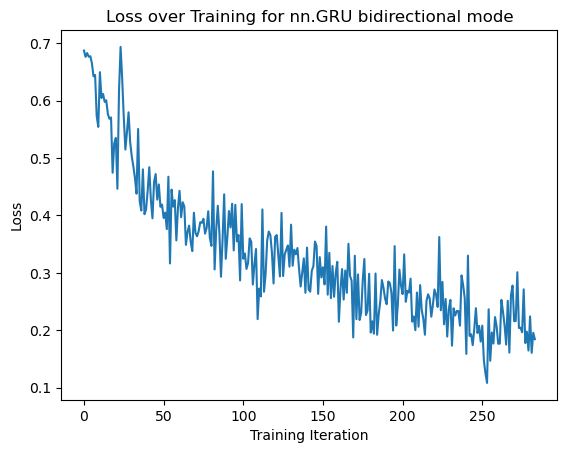

In [20]:
plt.plot(training_loss_tally_nnGRU_bidirectional)
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss over Training for nn.GRU bidirectional mode")

total acc for pos:        total acc for neg:
0.8335949764521193           0.8904358353510896
total accuracy: 0.8599494807746281
3563 3563


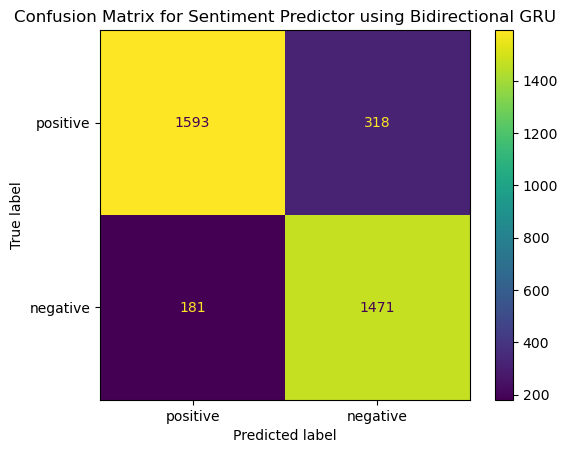

In [21]:
### Prediction / Eval Code for nn.GRU bidirectional
correct_pos_sentiment = 0.0
total_pos_sentiment = 0.0
correct_neg_sentiment = 0.0
total_neg_sentiment = 0.0
sentiment_pred = []
sentiment_label = []
mapping = { 0 : 'negative', 1: 'positive'}
with torch.no_grad():
    for n, data in enumerate(text_cl.dataserver_test):

            #print('n is', n)
            sentiment = data['sentiment']
            review = data['review']
            h = model_bidirectional.init_hidden()
            review = torch.unsqueeze(review, 1)
            out, h = model_bidirectional(review, h) #goes through one sequence of embeddings (i.e one review)

            GT = torch.argmax(sentiment).item()
            sentiment_label.append(mapping[GT])
            pred = torch.argmax(out[-1, :]).item()
            sentiment_pred.append(mapping[pred])
            if (GT == 1): #compute positive sentiment accuracy
                total_pos_sentiment += 1
                if pred == GT:
                    #print('accurate pos sentiment pred')
                    correct_pos_sentiment += 1

            if (GT == 0): #compute negative sentiment accuracy
                total_neg_sentiment += 1
                if pred == GT:
                    #print('accurate neg sentiment pred')
                    correct_neg_sentiment += 1


    print("total acc for pos:        total acc for neg:")       
    print(correct_pos_sentiment / total_pos_sentiment, '         ', correct_neg_sentiment / total_neg_sentiment)
    print('total accuracy:', (correct_pos_sentiment + correct_neg_sentiment) / len(sentiment_label))        
        
from sklearn.metrics import confusion_matrix
y_true = sentiment_label
y_pred = sentiment_pred
print(len(y_true), len(y_pred))
confusion_matrix=confusion_matrix(y_true, y_pred, labels = [ "positive", "negative"])
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels = [ "positive", "negative"])
disp.plot()
disp.ax_.set_title("Confusion Matrix for Sentiment Predictor using Bidirectional GRU")
plt.show()